# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import catboost as cb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)

# Set Random State

In [ ]:
global rand_state
rand_state = 2023

# Utility Functions

In [ ]:
def get_mean_cvs(model, X, y):
    global rand_state
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise', )
    
    print(f'Cross Validation Accuracy Score: {scores.mean():.3f} ({scores.std():.3f})')
    
    return scores


def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels))
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3, 
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='neg_log_loss',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None, 
                                 scoring='neg_log_loss', 
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'{mean} ({stdev}) with: {param}')
    print("Best Parameters: " +  str(grid_result.best_params_))
        
    return grid_result

# Load Dataset

In [2]:
X_train = pd.read_csv('./dataset/SmartLocal/X_train.csv')
y_train = pd.read_csv('./dataset/SmartLocal/y_train.csv')

X_test = pd.read_csv('./dataset/SmartLocal/X_test.csv')
y_test = pd.read_csv('./dataset/SmartLocal/y_test.csv')

# Scaling Data

In [ ]:
# Gradient descent and distance-based algorithms require feature scaling while tree-based algorithms do not.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 1. Gradient Boosting

## 1.1 CatBoost

Cross Validation Accuracy Score: 0.485 (0.027)
                precision    recall  f1-score   support

   High Shares       0.40      0.29      0.34       283
Average Shares       0.51      0.58      0.54       245
    Low Shares       0.49      0.58      0.53       271

      accuracy                           0.48       799
     macro avg       0.47      0.48      0.47       799
  weighted avg       0.47      0.48      0.47       799

Accuracy: 0.476


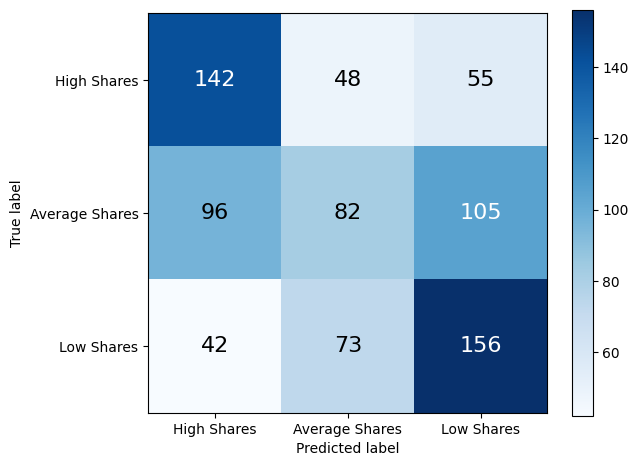

In [ ]:
cb_base_model = cb.CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1, 
    loss_function='MultiClass', 
    random_state=rand_state
)

get_mean_cvs(cb_base_model, X_train, y_train)

cb_base_model.fit(X_train, y_train, verbose=False)
y_pred_cb_base = cb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

In [ ]:
params = {
    'l2_leaf_reg': [1, 3, 5], 
}

cb_model = cb.CatBoostClassifier(loss_function='MultiClass', random_state=rand_state)

lr_best_params = get_best_params(model=cb_model,
                                 grid=params,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=True)

0:	learn: 1.0940975	total: 58.7ms	remaining: 58.6s
1:	learn: 1.0898361	total: 117ms	remaining: 58.3s
2:	learn: 1.0858310	total: 163ms	remaining: 54.2s
3:	learn: 1.0826232	total: 213ms	remaining: 53s
4:	learn: 1.0788204	total: 238ms	remaining: 47.4s
5:	learn: 1.0750121	total: 267ms	remaining: 44.2s
6:	learn: 1.0719622	total: 301ms	remaining: 42.7s
7:	learn: 1.0692931	total: 326ms	remaining: 40.5s
8:	learn: 1.0663904	total: 352ms	remaining: 38.8s
9:	learn: 1.0634669	total: 378ms	remaining: 37.5s
10:	learn: 1.0606726	total: 404ms	remaining: 36.3s
11:	learn: 1.0572511	total: 432ms	remaining: 35.5s
12:	learn: 1.0546178	total: 458ms	remaining: 34.8s
13:	learn: 1.0520108	total: 487ms	remaining: 34.3s
14:	learn: 1.0487213	total: 513ms	remaining: 33.7s
15:	learn: 1.0468066	total: 540ms	remaining: 33.2s
16:	learn: 1.0433922	total: 566ms	remaining: 32.7s
17:	learn: 1.0410259	total: 592ms	remaining: 32.3s
18:	learn: 1.0389071	total: 618ms	remaining: 31.9s
19:	learn: 1.0359661	total: 646ms	remainin

## 1.2 LightGBM

Cross Validation Accuracy Score: 0.467 (0.030)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


                precision    recall  f1-score   support

   High Shares       0.37      0.31      0.34       283
Average Shares       0.47      0.56      0.51       245
    Low Shares       0.51      0.51      0.51       271

      accuracy                           0.45       799
     macro avg       0.45      0.46      0.45       799
  weighted avg       0.45      0.45      0.45       799

Accuracy: 0.454


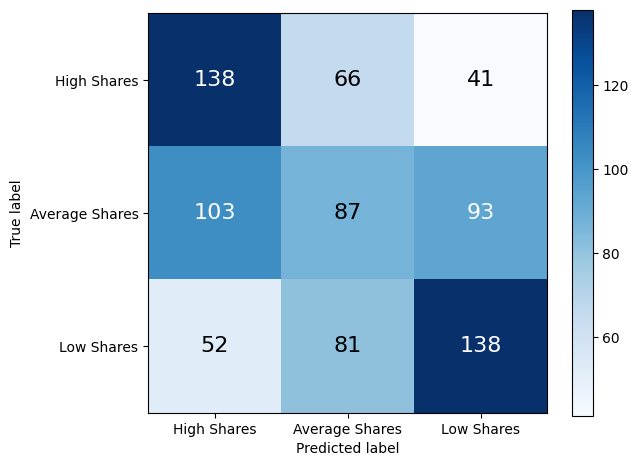

In [ ]:
lgb_base_model = lgb.LGBMClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    objective='multiclass', 
    metric='multi_logloss', 
    random_state=rand_state
)

get_mean_cvs(lgb_base_model, X_train, y_train)

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_base = lgb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

## 1.3 Adaboost

In [ ]:
def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

In [ ]:
ab_base_model =  AdaBoostClassifier(n_estimators=100, random_state=rand_state)
get_mean_cvs(ab_base_model, X_train, y_train)

Cross Validation Accuracy Score: 0.465 (0.028)


array([0.4375    , 0.453125  , 0.45625   , 0.44514107, 0.45454545,
       0.45454545, 0.47335423, 0.44827586, 0.46081505, 0.49216301,
       0.478125  , 0.4625    , 0.453125  , 0.49529781, 0.54231975,
       0.44200627, 0.42946708, 0.43887147, 0.42946708, 0.47962382,
       0.4625    , 0.453125  , 0.45      , 0.49216301, 0.50783699,
       0.4200627 , 0.48902821, 0.44827586, 0.4984326 , 0.51410658])

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                precision    recall  f1-score   support

   High Shares       0.39      0.31      0.34       283
Average Shares       0.47      0.56      0.51       245
    Low Shares       0.49      0.51      0.50       271

      accuracy                           0.45       799
     macro avg       0.45      0.46      0.45       799
  weighted avg       0.45      0.45      0.45       799



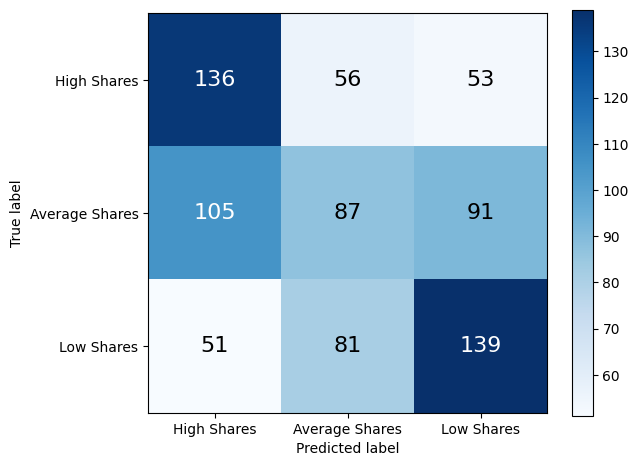

In [ ]:
ab_base_model.fit(X_train, y_train)
y_pred_ab_base = ab_base_model.predict(X_test)
evaluate_model(y_test, y_pred_ab_base)

In [ ]:
params = {"n_estimators": [25,50,100,200],
          "learning_rate": [0.01, 0.1, 1.0]
          }

ab_model =  AdaBoostClassifier()

ab_best_params = get_best_params(model=ab_model,
                                 grid=params,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: -1.0541577301039349 using {'n_estimators': 50, 'learning_rate': 0.01}
-1.0740981043462114 (0.001215878723778299) with: {'n_estimators': 50, 'learning_rate': 0.1}
-1.087260565245316 (0.001277844542557686) with: {'n_estimators': 25, 'learning_rate': 1.0}
-1.056803517977993 (0.0034705064728782708) with: {'n_estimators': 100, 'learning_rate': 0.01}
-1.0553976568272914 (0.009253704438363554) with: {'n_estimators': 25, 'learning_rate': 0.01}
-1.0926319435296699 (0.0013598535052255936) with: {'n_estimators': 100, 'learning_rate': 1.0}
-1.0629088276738767 (0.0023147464201517293) with: {'n_estimators': 200, 'learning_rate': 0.01}
-1.06488918359689 (0.0020278361933582364) with: {'n_estimators': 25, 'learning_rate': 0.1}
-1.0541577301039349 (0.005523629009765593) with: {'n_estimators': 50, 'learning_rate': 0.01}
-1.0948652574299433 (0.0008726738173769893) with: {'n_estimators': 200, 'learning_rate': 1.0}
-1.081502563637835 (0.0009455889552752935) with: {'n_estimators': 100, 'learning_rate':

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

                precision    recall  f1-score   support

   High Shares       0.00      0.00      0.00       283
Average Shares       0.41      0.67      0.51       245
    Low Shares       0.44      0.65      0.52       271

      accuracy                           0.43       799
     macro avg       0.28      0.44      0.34       799
  weighted avg       0.28      0.43      0.33       799



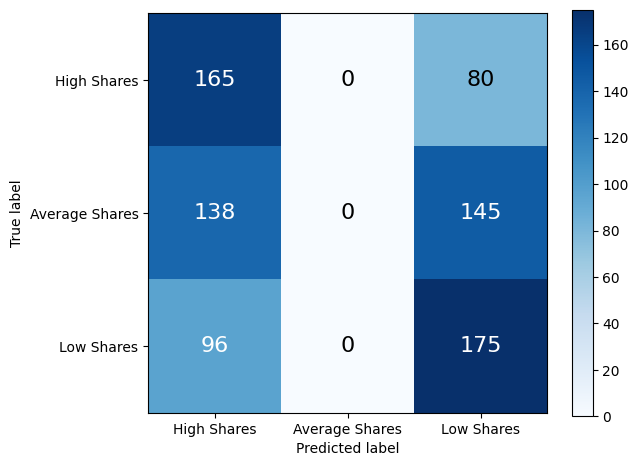

In [ ]:
# Parameters to be tuned (Runtime at 2h20mins)
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Placing parameters into a dictionary
parameters= {
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}
ab_best_model = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.01).fit(X_train, y_train)
y_pred_ab_best = ab_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ab_best)

In [ ]:
ab_best_model.feature_names_in_

array(['timedelta', 'n_tokens_title', 'n_tokens_preview',
       'preview_subjectivity', 'n_tokens_content', 'prop_non_stop',
       'prop_unique_non_stop', 'num_imgs', 'num_hrefs', 'n_tokens_cross',
       'subjectivity_cross', 'content_cross', 'subcategory1_Attractions',
       'subcategory1_Australia', 'subcategory1_Beauty & Wellness',
       'subcategory1_Food Guides', 'subcategory1_Malaysia',
       'subcategory1_Sales & Promotions',
       'author_category_100 to 200 posts',
       'author_category_More than 200 posts', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '0.1', '1.1', '2.1', '3.1', '4.1', '5.1',
       '6.1', '7.1', '8.1', '9.1', '0.2', '1.2', '2.2', '3.2', '4.2',
       '5.2', '6.2', '7.2', '8.2', '9.2'], dtype=object)

In [ ]:

pd.DataFrame({'feature': ab_best_model.feature_names_in_, 'score': ab_best_model.feature_importances_}).set_index('feature').squeeze().sort_values(ascending = False)[:10]

feature
timedelta    0.60
num_imgs     0.34
0.1          0.06
8.1          0.00
8            0.00
9            0.00
1.1          0.00
2.1          0.00
3.1          0.00
4.1          0.00
Name: score, dtype: float64

In [ ]:
evaluate_model(y_test, y_pred_ab_base)

In [ ]:
import pickle

path = f'/content/drive/My Drive/IS4242/datasets/ab_model.pkl'
pickle.dump(model, open(path,'wb'))

# 3. Random Forest


In [ ]:
mapping = {"Low Shares": 0, "Average Shares": 1, "High Shares": 2}

y_train['num_shares_bin'] = y_train['num_shares_bin'].map(mapping)
y_test['num_shares_bin'] = y_test['num_shares_bin'].map(mapping)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


rf = RandomForestClassifier()
np.random.seed(rand_state)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

<ipython-input-21-e4a8a26ae20a>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.49      0.51      0.50       271
           1       0.41      0.37      0.39       283
           2       0.48      0.52      0.50       245

    accuracy                           0.46       799
   macro avg       0.46      0.47      0.46       799
weighted avg       0.46      0.46      0.46       799



# 4. Convolutional Neural Network

In [ ]:
X_train = pd.read_csv('./drive/My Drive/IS4242/datasets/X_train.csv')
y_train = pd.read_csv('./drive/My Drive/IS4242/datasets/y_train.csv')

X_test = pd.read_csv('./drive/My Drive/IS4242/datasets/X_test.csv')
y_test = pd.read_csv('./drive/My Drive/IS4242/datasets/y_test.csv')

In [ ]:
mapping = {"Low Shares": 0, "Average Shares": 1, "High Shares": 2}

y_train['num_shares_bin'] = y_train['num_shares_bin'].map(mapping)
y_test['num_shares_bin'] = y_test['num_shares_bin'].map(mapping)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
import tensorflow
from tensorflow.keras.utils import to_categorical
# Reshape X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape y_train and y_test
# One-hot encode target variables
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)


In [ ]:
print(X_train.shape)
print(y_train_encode.shape)
print(X_test.shape)
print(y_test_encode.shape)

(3193, 50, 1)
(3193, 3)
(799, 50, 1)
(799, 3)


In [ ]:
# Import necessary libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow as tf

tf.keras.utils.set_random_seed(1)

# Build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=2,padding="same", activation="linear"))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size=2,padding="same", activation="linear"))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encode, epochs=25, batch_size=32, validation_data=(X_test, y_test_encode))


Epoch 1/25
100/100 [==============================] - 3s 18ms/step - loss: 6062.0186 - accuracy: 0.3276 - val_loss: 2420.8489 - val_accuracy: 0.3542
Epoch 2/25
100/100 [==============================] - 1s 14ms/step - loss: 2133.2334 - accuracy: 0.3288 - val_loss: 196.6582 - val_accuracy: 0.3392
Epoch 3/25
100/100 [==============================] - 1s 14ms/step - loss: 1103.0475 - accuracy: 0.3342 - val_loss: 246.6437 - val_accuracy: 0.3079
Epoch 4/25
100/100 [==============================] - 1s 15ms/step - loss: 660.2885 - accuracy: 0.3451 - val_loss: 119.7515 - val_accuracy: 0.3066
Epoch 5/25
100/100 [==============================] - 2s 16ms/step - loss: 405.5176 - accuracy: 0.3276 - val_loss: 65.4854 - val_accuracy: 0.3579
Epoch 6/25
100/100 [==============================] - 2s 22ms/step - loss: 230.8657 - accuracy: 0.3335 - val_loss: 27.8691 - val_accuracy: 0.3517
Epoch 7/25
100/100 [==============================] - 3s 31ms/step - loss: 131.4828 - accuracy: 0.3398 - val_loss: 2

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on test data
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.flatten(), y_pred))

25/25 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.41      0.73      0.52       271
           1       0.35      0.37      0.36       283
           2       0.61      0.04      0.08       245

    accuracy                           0.39       799
   macro avg       0.46      0.38      0.32       799
weighted avg       0.45      0.39      0.33       799



# Model Evaluation